In [1]:
import os
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras import backend as K
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [95]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

CH_CODE = ["CONV_2_1_3", "CONV_2_1_4", "CONV_2_1_5"]
classes = CH_CODE
snrs = list(range(-20, 21, 2))

Device found : []


In [132]:
base_dir = r"C:\Users\USER-PC\haneol\DATASET_GAF"

# x_train = np.load(base_dir + r"\x_train.npy", allow_pickle=True)
x_train = np.load(base_dir + r"\x_train_gasf.npy", allow_pickle=True)
y_train = np.load(base_dir + r"\y_train.npy", allow_pickle=True)

# x_test = np.load(base_dir + r"\x_test.npy", allow_pickle=True)
x_test = np.load(base_dir + r"\x_test_gasf.npy", allow_pickle=True)
y_test = np.load(base_dir + r"\y_test.npy", allow_pickle=True)

x_val = np.load(base_dir + r"\x_val.npy", allow_pickle=True)
y_val = np.load(base_dir + r"\y_val.npy", allow_pickle=True)

lbl = np.load(base_dir + r"\lbl.npy", allow_pickle=True).tolist()
train_idx = np.load(base_dir + r"\train_idx.npy", allow_pickle=True).tolist()
test_idx = np.load(base_dir + r"\test_idx.npy", allow_pickle=True).tolist()
val_idx = np.load(base_dir + r"\val_idx.npy", allow_pickle=True).tolist()

x_test1d = np.reshape(x_test, (-1, 128))
x_train1d = np.reshape(x_train, (-1, 128))
x_val1d = np.reshape(x_val, (-1, 128))

filepath = r"C:\Users\USER-PC\haneol\best_model.keras"

In [136]:
def train(model):
    resume = True
    filepath = "best_model.keras"  # 저장할 모델 파일명
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                 save_best_only=True, mode='max')
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=2)
    callbacks_list = [checkpoint, earlystopping]
    history = model.fit(x_train, y_train, epochs=200, batch_size=256, verbose=1, # batch_size=1024 -> 256
                            # validation_data=(x_test, y_test),
                            validation_data=(x_val, y_val),
                            callbacks=callbacks_list)
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Baseline Error: %.2f%%' % (100 - score[1] * 100))
    
    return history

In [97]:
def test(model):
    acc = {}
    for snr in snrs:
        test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
        test_X_i = x_test[np.where(np.array(test_SNRs) == str(snr))]
        test_Y_i = y_test[np.where(np.array(test_SNRs) == str(snr))]
        
        print(test_X_i)
        print(test_X_i.shape)
                
        print(f"\nTesting at SNR {snr} dB:")
        test_Y_i_hat = model.predict(test_X_i)
        
        conf = np.zeros([len(classes), len(classes)])
        for i in range(test_X_i.shape[0]):
            j = list(test_Y_i[i, :]).index(1)
            k = int(np.argmax(test_Y_i_hat[i, :]))
            conf[j, k] += 1
        
        confnorm = conf / np.sum(conf, axis=1, keepdims=True)
        
        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        accuracy = cor / (cor + ncor)
        print(f"Overall Accuracy: {accuracy}")
        
        acc[snr] = accuracy
    
    # Plot accuracy by SNR
    plt.figure()
    plt.plot(snrs, [acc[snr] for snr in snrs], marker='o')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy by SNR')
    plt.grid(True)
    plt.show()

In [73]:
def plot_confusion_matrix(cm, labels=[], title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [110]:
def SNR_accuracy(in_snr, model, name, x_test, y_test):
    acc = []
    for snr in in_snr:
        idx_acc_snr = [i for i in range(len(test_idx)) if lbl[test_idx[i]][1] == snr]
        acc_X_test = x_test[idx_acc_snr]
        acc_Y_test = y_test[idx_acc_snr]
        
        print('\nSNR ' + str(snr) + 'dB:')
        accuracy_snr = model.evaluate(acc_X_test, acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)
    acc = np.vstack(acc)
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(in_snr, (acc[:,1]*100), 'steelblue', marker='.', markersize=15, label=name, linestyle='-')
    ax.legend(loc=4, prop={'size': 25})
    
    ax.set_xticks(np.arange(-20, 21, 2))
    ax.set_yticks(np.arange(0, 101, 10))
    
    ax.grid(which='both', color='lightgray', linestyle='-')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    
    ax.set_xlim(-21, 21)
    ax.set_ylim(0, 100)
    
    ax.set_title("Classification Accuracy", fontsize=20)
    ax.set_ylabel('Accuracy (%)', fontsize=20)
    ax.set_xlabel('SNR (dB)', fontsize=20)
    
    plt.show()
    
    return acc[:,1]

In [143]:
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.models import Model

k_size = (1, 2)
p_size = (1, 2)

cnn_in = Input(shape=(1, 128, 1))

cnn = Conv2D(filters=32, kernel_size=k_size, activation='relu')(cnn_in) 
cnn = MaxPool2D(pool_size=p_size)(cnn)
cnn = Dropout(rate=0.2)(cnn)

cnn = Conv2D(filters=32, kernel_size=k_size, activation='relu')(cnn) 
cnn = MaxPool2D(pool_size=p_size)(cnn)
cnn = Dropout(rate=0.2)(cnn)

cnn = Conv2D(filters=32, kernel_size=k_size, activation='relu')(cnn) 
cnn = MaxPool2D(pool_size=p_size)(cnn)
cnn = Dropout(rate=0.2)(cnn)

cnn = Flatten()(cnn)  
cnn = Dense(120, activation='relu')(cnn)
cnn = Dense(60, activation='relu')(cnn)

cnn_out = Dense(len(classes), activation='softmax')(cnn)

model_cnn = Model(cnn_in, cnn_out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_cnn.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 1, 128, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 1, 127, 32)     │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 1, 63, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1, 63, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 1, 62, 32)      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 1, 31, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 1, 31, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 1, 30, 32)      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 1, 15, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 1, 15, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 120)            │        57,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           183 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,419 (271.17 KB)

 Trainable params: 69,419 (271.17 KB)

 Non-trainable params: 0 (0.00 B)

In [144]:
history = train(model_cnn)

Epoch 1/200
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3312 - loss: 1.3507
Epoch 1: val_accuracy improved from -inf to 0.31619, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3310 - loss: 1.3476 - val_accuracy: 0.3162 - val_loss: 1.2718
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3339 - loss: 1.2530
Epoch 2: val_accuracy improved from 0.31619 to 0.34286, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3338 - loss: 1.2523 - val_accuracy: 0.3429 - val_loss: 1.2018
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3310 - loss: 1.1906
Epoch 3: val_accuracy improved from 0.34286 to 0.34317, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3309 - loss: 1.1902 - val_accuracy: 0.3432 - val_loss: 1.1598
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3379 - loss: 1.1531
Epoch 4: val_accuracy did not improve from 0

In [ ]:
test(model_cnn)

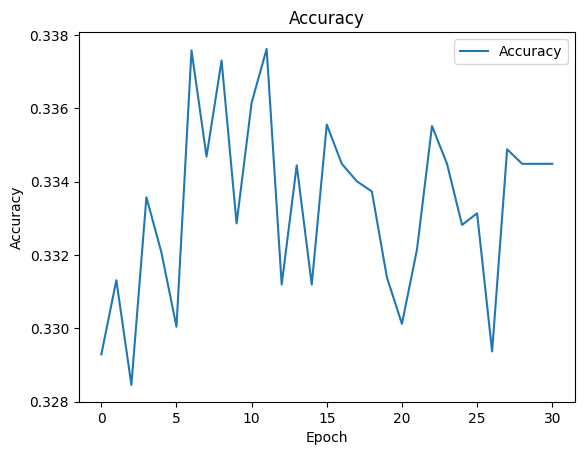

In [145]:
# Acc의 추이 확인
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy'], loc='upper right')
plt.show()


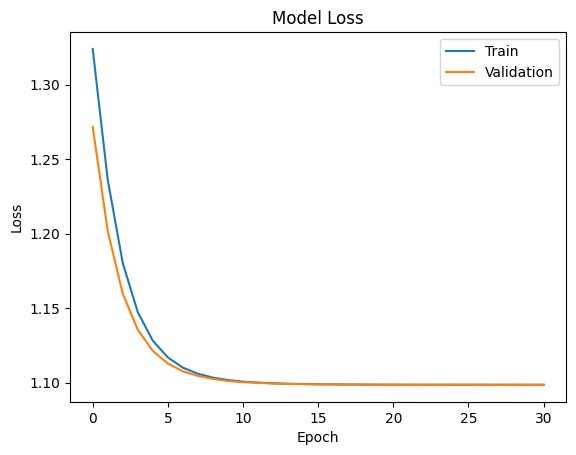

In [146]:
# 학습 손실과 검증 손실의 추이 확인
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


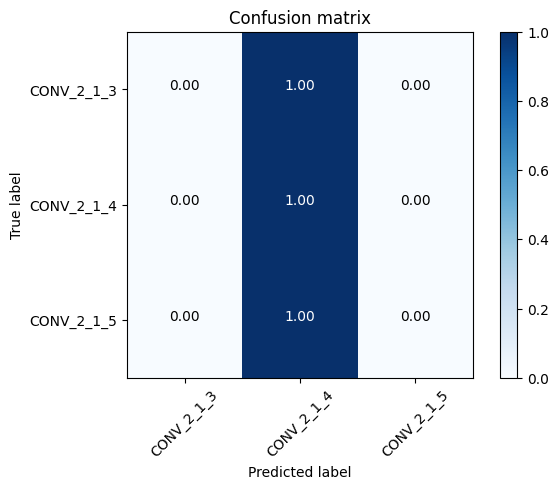

In [147]:
y_predict = model_cnn.predict(x_test)

# Calculate confusion matrix
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,x_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
# Plot confusion matrix
plot_confusion_matrix(confnorm, labels=classes)


SNR -20dB:
6/6 - 0s - 7ms/step - accuracy: 0.3452 - loss: 1.0985

SNR -18dB:
5/5 - 0s - 6ms/step - accuracy: 0.2993 - loss: 1.0989

SNR -16dB:
5/5 - 0s - 7ms/step - accuracy: 0.3567 - loss: 1.0985

SNR -14dB:
5/5 - 0s - 6ms/step - accuracy: 0.2710 - loss: 1.0989

SNR -12dB:
5/5 - 0s - 6ms/step - accuracy: 0.2722 - loss: 1.0989

SNR -10dB:
5/5 - 0s - 6ms/step - accuracy: 0.2535 - loss: 1.0990

SNR -8dB:
5/5 - 0s - 6ms/step - accuracy: 0.2414 - loss: 1.0992

SNR -6dB:
6/6 - 0s - 5ms/step - accuracy: 0.3576 - loss: 1.0985

SNR -4dB:
5/5 - 0s - 6ms/step - accuracy: 0.3052 - loss: 1.0989

SNR -2dB:
5/5 - 0s - 6ms/step - accuracy: 0.3179 - loss: 1.0987

SNR 0dB:
5/5 - 0s - 6ms/step - accuracy: 0.3404 - loss: 1.0986

SNR 2dB:
5/5 - 0s - 6ms/step - accuracy: 0.3356 - loss: 1.0986

SNR 4dB:
5/5 - 0s - 6ms/step - accuracy: 0.3742 - loss: 1.0984

SNR 6dB:
5/5 - 0s - 6ms/step - accuracy: 0.3431 - loss: 1.0985

SNR 8dB:
5/5 - 0s - 6ms/step - accuracy: 0.2829 - loss: 1.0989

SNR 10dB:
4/4 - 0s - 7m

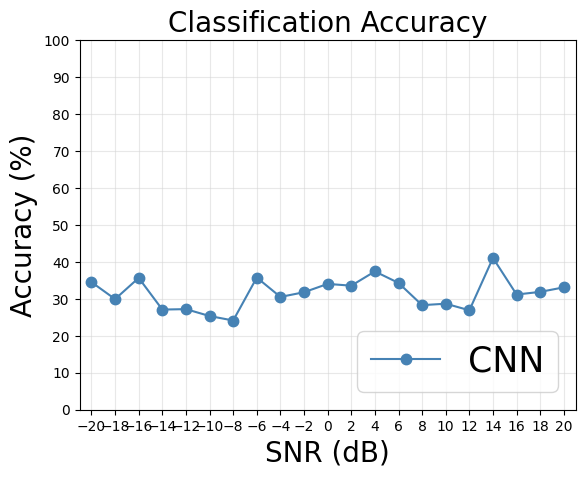

In [148]:
# Plot classfication accuracy by each SNR
acc = SNR_accuracy(snrs, model_cnn, 'CNN', x_test, y_test)

In [123]:
acc = []
for snr in snrs:
    idx_acc_snr = [i for i in range(len(test_idx)) if lbl[test_idx[i]][1] == snr]
    acc_X_test = x_test[idx_acc_snr]
    acc_Y_test = y_test[idx_acc_snr]
    
    print('\nSNR ' + str(snr) + 'dB:')
    accuracy_snr = model_cnn.evaluate(acc_X_test, acc_Y_test, batch_size=128, verbose=2)
    acc.append(accuracy_snr)
acc = np.vstack(acc)


SNR -20dB:
4/4 - 0s - 9ms/step - accuracy: 0.4126 - loss: 1.1146



SNR -18dB:
4/4 - 0s - 8ms/step - accuracy: 0.4391 - loss: 1.0341

SNR -16dB:
4/4 - 0s - 8ms/step - accuracy: 0.4661 - loss: 1.0765

SNR -14dB:
4/4 - 0s - 8ms/step - accuracy: 0.4372 - loss: 1.0789

SNR -12dB:
4/4 - 0s - 8ms/step - accuracy: 0.4344 - loss: 1.0731

SNR -10dB:
4/4 - 0s - 8ms/step - accuracy: 0.4165 - loss: 1.0982

SNR -8dB:
4/4 - 0s - 8ms/step - accuracy: 0.4659 - loss: 1.0108

SNR -6dB:
4/4 - 0s - 7ms/step - accuracy: 0.4632 - loss: 1.0467

SNR -4dB:
4/4 - 0s - 8ms/step - accuracy: 0.4279 - loss: 1.0901

SNR -2dB:
4/4 - 0s - 8ms/step - accuracy: 0.4265 - loss: 1.0692

SNR 0dB:
4/4 - 0s - 8ms/step - accuracy: 0.4375 - loss: 1.0686

SNR 2dB:
4/4 - 0s - 8ms/step - accuracy: 0.3929 - loss: 1.1012

SNR 4dB:
4/4 - 0s - 8ms/step - accuracy: 0.4644 - loss: 1.0290

SNR 6dB:
4/4 - 0s - 8ms/step - accuracy: 0.4229 - loss: 1.0789

SNR 8dB:
4/4 - 0s - 7ms/step - accuracy: 0.4468 - loss: 1.0457

SNR 10dB:
4/4 - 0s - 8ms/step - accuracy: 0.4401 - loss: 1.0171

SNR 12dB:
4/4 - 0s - 8ms

In [125]:
test_SNRs = list(map(lambda x: lbl[x][1], test_idx))

print(test_SNRs)

[-8, -4, -2, -14, -16, -14, 4, -6, 2, 18, 14, 14, 20, 12, -8, -2, -2, -18, 20, -2, 18, -18, -2, 2, 4, 18, 6, 18, 2, -14, 12, -10, -16, 12, -4, -14, 20, -6, 2, -8, 6, -14, -4, 4, 14, 6, 14, -8, 14, -20, 2, 14, -12, -4, -8, 6, 8, -2, 20, -4, 14, 4, 12, -18, 12, -18, 18, -10, -16, -4, -14, 6, 10, 10, -16, -18, 6, 6, -2, 16, -8, 4, 6, 8, 8, -16, 8, -2, 10, 20, 16, -4, -8, -8, -8, 6, 10, -8, -12, -2, -18, -20, -2, 6, -16, -6, -18, -4, 4, -20, -10, -10, 10, -6, 20, 14, 6, 4, 18, 2, 10, 16, 0, 4, 6, 10, 12, -2, -18, -10, -10, -4, 6, -18, -16, -12, -8, -10, -4, 0, 16, 20, -18, 12, -12, 16, 12, 4, 8, 10, -4, 18, -2, -16, 14, -2, -12, 14, 2, 4, 4, -16, -8, -18, -10, -10, -20, -14, 0, -20, -8, -14, -10, -14, 16, -4, 20, -14, -10, 18, 6, -18, 16, 16, 14, -10, -16, 2, -4, -2, -10, -16, -14, 16, 16, 0, -20, -4, 6, -16, -18, 18, 16, 0, -6, 12, 2, 0, -10, 14, 20, 20, -6, -18, -2, -8, 4, 20, 6, -8, -18, -2, -18, 10, -6, -12, 18, 18, -14, -12, 10, -20, 10, 8, -2, -16, 18, 2, 18, -6, 12, 20, -4, 12, -8, 